In [18]:
import sys
sys.path.append("/home/jovyan/waymo-open-dataset") 
import tensorflow as tf

from scripts.iab import AttPredictorPecNet, AttPredictorPecNetWithType
from scripts.train import train_multymodal, create_subm
from scripts.visualize import vis_cur_and_fut
from scripts.train import get_speed_ade_with_mask, get_ade_from_pred_speed_with_mask
from scripts.config import build_parser
from scripts.models import Checkpointer
from scripts.dataloaders import context_description, CustomImageDataset, d_collate_fn

tf.get_logger().setLevel('ERROR')

import torch

from tqdm.auto import tqdm
import torch.utils.data

import matplotlib.pyplot as plt
import numpy as np
import wandb
import random
import torch.optim as optim
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
import os
from scripts.rgb_loader import RgbLoader
from scripts.train import preprocess_batch, apply_tr

In [19]:
# list(context_description.keys())

In [20]:
# # pip install transformers
# keys_to_remove = []
# for key in context_description.keys():
#     if "roadgraph" in key or "traffic_light_state" in key :
#         print (key)
#         keys_to_remove.append(key)

# for key in keys_to_remove:
#     del context_description[key]

In [21]:

batch_size = 8
dir_data = "/home/jovyan/uncompressed/tf_example"
test_path = os.path.join(dir_data, "validation/validation_tfexample.tfrecord-*-of-00150")
test_dataset = CustomImageDataset(test_path, context_description)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          num_workers=0, collate_fn=d_collate_fn)


train dataset containing 150 files


In [22]:
# counter = 0
# for data in tqdm(test_loader):
#     counter+=1
#     if counter>10:
#         break

In [23]:
# counter = 0
# for data in tqdm(test_loader):
#     counter+=1
#     if counter>10:
#         break

In [42]:
net = AttPredictorPecNetWithType(inp_dim=1024, embed_dim=256, num_blocks=4,
                         out_modes=6, use_vis=1, use_rec=0,
                         use_points=0, out_horiz=80)
net = torch.nn.DataParallel(net)
net.load_state_dict(
            torch.load("/home/jovyan/waymo-open-dataset/tutorial/model-seed-0-epoch-2_1024.pt", map_location="cuda"))

loaded index file contains 6806.0 indexes to files


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/waymo-open-dataset/tutorial/model-seed-0-epoch-2_102.pt'

In [9]:
net.to("cuda")

net.eval()
pass

In [10]:
from waymo_open_dataset.protos import motion_submission_pb2

In [11]:
motion_challenge_submission = motion_submission_pb2.MotionChallengeSubmission()

motion_challenge_submission.account_name = "alex.postnikov@skolkovotech.ru"
authors = "postnikov,gamaynov"
# motion_challenge_submission.authors.extend(authors.split(","))
motion_challenge_submission.submission_type = (
    motion_submission_pb2.MotionChallengeSubmission.SubmissionType.MOTION_PREDICTION
)
motion_challenge_submission.unique_method_name = "iab"


In [12]:
rgb_loader = RgbLoader("/home/jovyan/waymo-open-dataset/tutorial/rendered/val/index.pkl")

loaded index file contains 1234.0 indexes to files


In [13]:
RES = {}
with torch.no_grad():
    for data in tqdm(test_loader, total=int(22000 * 128 // 479 * 150 // test_loader.batch_size)):
        if rgb_loader is not None:
            pass
            data["rgbs"] = torch.tensor(rgb_loader.load_batch_rgb(data, prefix="").astype(np.float32))
        batch_unpacked = preprocess_batch(data, 0, 1)
        logits, confidences, goals, rot_mat, rot_mat_inv = net.module(batch_unpacked)
        logits = apply_tr(logits, rot_mat_inv)
        logits = logits.cpu().numpy()
        confidences = confidences.cpu().numpy()
        mask = data["state/tracks_to_predict"].reshape(-1, 128) > 0
        agent_id = data["state/id"].cpu()[mask].numpy()
        scenario_id = data["scenario/id"]
        try:
            scenario_id = [sc.numpy().tobytes().decode("utf-8") for sc in scenario_id]
        except:
            pass
        scenarios_id = []
        for bn, scenario in enumerate(scenario_id):
            [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]
        for p, conf, aid, sid in zip(
                logits, confidences, agent_id, scenarios_id):
            if sid not in RES:
                RES[sid] = []

            RES[sid].append(
                {"aid": aid, "conf": conf, "pred": p}
            )
            

  0%|          | 0/110212 [00:00<?, ?it/s]

/home/jovyan/waymo-open-dataset/tutorial/scripts/rgb_loader.py:74: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  num_nonzero_in_each_batch = (mask.nonzero()[:, 0] == bn).sum()


In [14]:
selector = np.arange(4, 80 + 1, 5)
for scenario_id, data in tqdm(RES.items()):
    scenario_predictions = motion_challenge_submission.scenario_predictions.add()
    scenario_predictions.scenario_id = scenario_id
    prediction_set = scenario_predictions.single_predictions

    for d in data:
        predictions = prediction_set.predictions.add()
        predictions.object_id = int(d["aid"])

        for i in np.argsort(-d["conf"]):
            scored_trajectory = predictions.trajectories.add()
            scored_trajectory.confidence = d["conf"][i]

            trajectory = scored_trajectory.trajectory

            p = d["pred"][selector, i]  # @ rot_matrix + d["center"]

            trajectory.center_x.extend(p[:, 0])
            trajectory.center_y.extend(p[:, 1])

with open("subm_file.pb", "wb") as f:
    f.write(motion_challenge_submission.SerializeToString())
# return

  0%|          | 0/44097 [00:00<?, ?it/s]

In [156]:
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Optimizer
import math

def get_cosine_with_hard_restarts_schedule_with_warmup_with_min(
    optimizer: Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: int = 1, last_epoch: int = -1, minumal_coef: float = 0.2
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, with several hard restarts, after a warmup period during which it increases
    linearly between 0 and the initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        num_cycles (:obj:`int`, `optional`, defaults to 1):
            The number of hard restarts to use.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        if progress >= 1.0:
            return 0.0
        return max(minumal_coef, 0.5 * (1.0 + math.cos(math.pi * ((float(num_cycles) * progress) % 1.0))))

    return LambdaLR(optimizer, lr_lambda, last_epoch)
# return LambdaLR(optimizer, lr_lambda, last_epoch)



In [157]:
import matplotlib.pyplot as plt

In [166]:
test = torch.autograd.Variable(torch.randn([5,5]), requires_grad=True)
optimizer = torch.optim.Adam([test], lr = 1.)
lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup_with_min(optimizer, num_warmup_steps=10, num_training_steps=60, num_cycles=3, last_epoch = -1, minumal_coef= 0.4)
lrs = []
for i in range(40):
    lr_scheduler.step()
    lrs.append(lr_scheduler.get_lr())


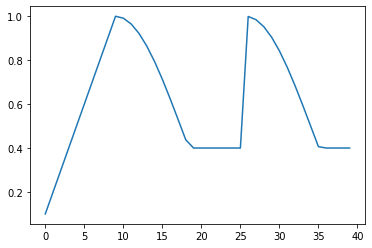

In [167]:
plt.plot(lrs)

In [133]:
# data["rgbs"] = torch.tensor(rgb_loader.load_batch_rgb(data, prefix="").astype(np.float32))
# batch_unpacked = preprocess_batch(data, 0, 1)
# logits, confidences, goals, rot_mat, rot_mat_inv = net(batch_unpacked)


torch.Size([4, 80, 6, 2])

In [130]:
# masks, rot_mat, rot_mat_inv, state_masked, xyz_personal, maps = batch_unpacked
# state_masked.shape
# bsr = state_masked.shape[0]
# bsr

8

In [76]:
ms = motion_submission_pb2.MotionChallengeSubmission()

In [144]:
for i, sp in enumerate(motion_challenge_submission.scenario_predictions):
    if sp.scenario_id == "bd78ffacefd79de7":
        # print(sp)
        for single_pred in sp.single_predictions.predictions:
            print (single_pred)

object_id: 445
trajectories {
  trajectory {
    center_x: 1895.3133544921875
    center_x: 1895.3258056640625
    center_x: 1895.44140625
    center_x: 1895.5224609375
    center_x: 1895.62158203125
    center_x: 1895.708984375
    center_x: 1895.7034912109375
    center_x: 1895.476806640625
    center_x: 1894.8070068359375
    center_x: 1893.8167724609375
    center_x: 1892.3365478515625
    center_x: 1890.168701171875
    center_x: 1887.5107421875
    center_x: 1884.1478271484375
    center_x: 1880.4248046875
    center_x: 1876.08984375
    center_y: -8232.736328125
    center_y: -8229.830078125
    center_y: -8226.4912109375
    center_y: -8222.7705078125
    center_y: -8218.7314453125
    center_y: -8214.423828125
    center_y: -8210.01171875
    center_y: -8205.5078125
    center_y: -8201.1689453125
    center_y: -8196.7333984375
    center_y: -8192.423828125
    center_y: -8188.35546875
    center_y: -8184.8037109375
    center_y: -8181.49755859375
    center_y: -8178.7802734375

In [99]:
mcs = motion_submission_pb2.MotionChallengeSubmission()
f = open("/home/jovyan/waymo-open-dataset/tutorial/out.pb", "rb")
mcs.ParseFromString(f.read())
f.close()

In [102]:
for i, sp in enumerate(mcs.scenario_predictions):
    if sp.scenario_id == "bd78ffacefd79de7":
        for single_pred in sp.single_predictions.predictions:
            print (single_pred.object_id)

445
449
451
452
445
449
451
452
445
449
451
452
445
449
451
452
445
449
451
452


In [7]:
import matplotlib.pyplot as plt

In [8]:
class Config():
    exp_inp_dim = 512
    exp_embed_dim = 128
    exp_num_blocks = 4
    exp_use_vis = 1
    exp_use_rec=0
    exp_use_points=0
    use_every_nth_prediction=1
    exp_lr=3e-5
    exp_batch_size=32
    exp_num_epochs=5
    dir_checkpoint = "./checkpoints/"
    epoch_to_load= -1
    exp_name="intial_jup"

In [9]:
config = Config()

In [11]:
# !wandb offline

In [10]:
wandb.init(project="waymo22_map", entity="aleksey-postnikov", name=config.exp_name)
wandb.config = {
    "learning_rate": config.exp_lr,
    "epochs": config.exp_num_epochs,
    "batch_size": config.exp_batch_size
}

2022-04-19 22:46:29.347985: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [12]:
device = "cuda"

net = AttPredictorPecNet(inp_dim=config.exp_inp_dim, embed_dim=config.exp_embed_dim, num_blocks=config.exp_num_blocks,
                         out_modes=6, use_vis=config.exp_use_vis, use_rec=config.exp_use_rec,
                         use_points=config.exp_use_points, out_horiz=80//config.use_every_nth_prediction)
net = torch.nn.DataParallel(net)


optimizer = optim.Adam(net.parameters(), lr=config.exp_lr)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=20,
            num_training_steps=(22000*128 / config.exp_batch_size) * config.exp_num_epochs,
            num_cycles=config.exp_num_epochs) 
net = net.to(device)

checkpointer = Checkpointer(model=net, torch_seed=0, ckpt_dir=config.dir_checkpoint, checkpoint_frequency=1)
net = checkpointer.load(config.epoch_to_load)


99000.0
98000.0
97000.0
96000.0
95000.0
94000.0
training from scratch


In [13]:
train_multymodal(net, (train_loader, test_dataset), optimizer, checkpointer=checkpointer,
                 num_ep=wandb.config["epochs"],
                 logger=wandb, use_every_nth_prediction=config.use_every_nth_prediction, scheduler=scheduler)

0it [00:00, ?it/s]

subm2-0:40731:40731 [0] NCCL INFO Bootstrap : Using [0]eth0:10.233.116.35<0>
subm2-0:40731:40731 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so).
subm2-0:40731:40731 [0] NCCL INFO NET/IB : No device found.
subm2-0:40731:40731 [0] NCCL INFO NET/Socket : Using [0]eth0:10.233.116.35<0>
NCCL version 2.4.8+cuda10.1
subm2-0:40731:40731 [0] NCCL INFO nranks 2
subm2-0:40731:40731 [0] NCCL INFO Setting affinity for GPU 0 to ffffff00,0000ffff,ff000000
subm2-0:40731:40731 [1] NCCL INFO Setting affinity for GPU 1 to ffffff00,0000ffff,ff000000
subm2-0:40731:40731 [1] NCCL INFO Using 256 threads, Min Comp Cap 7, Trees disabled
subm2-0:40731:40731 [1] NCCL INFO Channel 00 :    0   1
subm2-0:40731:40731 [1] NCCL INFO Channel 01 :    0   1
subm2-0:40731:40731 [1] NCCL INFO Channel 02 :    0   1
subm2-0:40731:40731 [1] NCCL INFO Channel 03 :    0   1
subm2-0:40731:40731 [1] NCCL INFO Channel 04 :    0   1
subm2-0:40731:40731 [1] NCCL INFO Channel 05 :    0   1
subm2-0:40731:40731 [1] NCCL IN

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jovyan/waymo-open-dataset/tutorial/scripts/iab.py", line 504, in forward
    x = self.encoder(x, img_emb, agent_h_emb, xyz_emb)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jovyan/waymo-open-dataset/tutorial/scripts/iab.py", line 255, in forward
    x = pose_encoder(x, image_emb, agent_h_emb, points_emb)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jovyan/waymo-open-dataset/tutorial/scripts/iab.py", line 236, in forward
    x = x + self.va(image_emb, x)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jovyan/waymo-open-dataset/tutorial/scripts/iab.py", line 210, in forward
    value = self.v_mlp(resnet_out).unsqueeze(1).permute(1, 0, 2)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 91, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/user/conda/lib/python3.7/site-packages/torch/nn/functional.py", line 1674, in linear
    ret = torch.addmm(bias, input, weight.t())
RuntimeError: mat1 dim 1 must match mat2 dim 0


In [ ]:
np.random.rand(1).flags

In [4]:
rgb_loader = RgbLoader(index_path="rendered/val/index.pkl")

loaded index file contains 1234.0 indexes to files


In [6]:
for data in tqdm(train_loader):
    batch = data['scenario/id']
    mask = (data["state/tracks_to_predict"] > 0)
    aids = data["state/id"][mask>0]
    rgb = rgb_loader.load_batch_rgb(data, prefix="").astype(np.float32)
    

0it [00:00, ?it/s]

/home/jovyan/waymo-open-dataset/tutorial/scripts/rgb_loader.py:73: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]


KeyboardInterrupt: 

In [ ]:
# plt.imshow(rgb[6])

In [ ]:
aid

In [ ]:
data["state/id"]

In [ ]:
for data in tqdm(train_loader):
    rgb = rgb_loader.load_batch_rgb(data, prefix="").astype(np.float32)
    assert rgb is not None